# Archival Novelty

This notebook explores whether requests to archive web resources were the first such request. Or rather, whether the request provided the Internet Archive with first knowledge of the web resource. Let's call this *archival novelty* which will be the percentage of SavePageNow requests which brought new knowledge of a URL to the Internet Archive. We are specifically going to look at *archival novelty* in terms of SavePageNow requests from automated and human agents.

The Internet Archive's [CDX API](https://github.com/internetarchive/wayback/tree/master/wayback-cdx-server) can tell us exactly when a given URL has been archived over time. But there are 7 million requests for HTML pages in our dataset. So what we will do is randomly sample the requests and check those against the CDX API.

First we will read in the URLS csv data that we generated in the URLs notebook back into a Spark DataFrame. Remember this only SavePageNow requests that resulted in an HTML responses, so it doesn't include things like images, JavaScript or CSS that SavePageNow could request when proxying an actual browser.

In [1]:
import sys
sys.path.append('../utils')

from warc_spark import init

sc, sqlc = init()
df = sqlc.read.csv('results/urls', header=True)

## Create Samples

Lets look specifically at 2018. Since millions of SavePageNow requests were received, and it's not feasible to query the CDX API millions of times, we will generate a random sample. Since we know the size of the population (number of requests) we will use the [Yamane Method](http://www.research-system.siam.edu/images/independent/Consumer_acceptance_of_air_purifier_products_in_China/CHAPTER_3.pdf) to calculate the sample size needed for a confidence interval of 5% and a confidence level of 95%.

In [74]:
import pandas

year = df.filter(df.date.like('2018%'))
pop_size = year.count()
sample_size = int(pop_size / (1 + pop_size * (.05**2)))
sample_list = year.rdd.takeSample(withReplacement=False, num=sample_size, seed=42)

print("sample size:", len(sample_list))

sample size: 399


In [84]:
print(sample_list[0])

Row(record_id='<urn:uuid:e70603a2-096a-4f82-b66d-7bc2bb5f286e>', warc_file='warcs/liveweb-20181025043139/live-20181025035248-wwwb-app53.us.archive.org.warc.gz', date='2018-10-25T04:12:23Z', url='http://eestipaevaleht.se/', user_agent='Python-urllib/2.7', user_agent_family='Python-urllib', bot='true')


In [87]:
sample = pandas.DataFrame(sample_list, columns=year.schema.fieldNames())
sample = sample.set_index('record_id')
sample.head()

,warc_file,date,url,user_agent,user_agent_family,bot
record_id,,,,,,
<urn:uuid:e70603a2-096a-4f82-b66d-7bc2bb5f286e>,warcs/liveweb-20181025043139/live-201810250352...,2018-10-25T04:12:23Z,http://eestipaevaleht.se/,Python-urllib/2.7,Python-urllib,true
<urn:uuid:8d3949bd-c7c4-45a1-b11f-90a0975de679>,warcs/liveweb-20181025212424/live-201810252105...,2018-10-25T21:23:14Z,http://km.aifb.kit.edu/projects/numbers/web/n2...,Wget/1.19.4 (darwin17.3.0),Wget,true
<urn:uuid:87c47520-05d9-47ac-b8b5-79408549caff>,warcs/liveweb-20181025170957/live-201810251658...,2018-10-25T17:05:13Z,https://socialblade.com/youtube/channel/UCCmXc...,Wget/1.19.5 (linux-gnu),Wget,true
<urn:uuid:0b7d69ca-d38c-4d6c-9f91-bcb63c82265c>,warcs/liveweb-20181025000937/cachegw-201810240...,2018-10-24T13:44:56Z,https://www.reg.ru/domain/shop/lot/rockderzhav...,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,true
<urn:uuid:572b5006-3a51-43df-94fc-95ccfea727af>,warcs/liveweb-20181025165702/live-201810251631...,2018-10-25T16:47:20Z,http://abelhas.pt/action/LastAccounts/LastSeen...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:63...,Firefox,false


## Add Novelty

Now let's create a function that will return all the times a URL was archived. If supplied the `to` parameter will limit the results to snapshots that were taken prior to (and including) that time. This will limit the results we need to collect since we don't really need to know how many times a URL was collected *after* the time in question.

In [11]:
import requests

def archive_times(url, to=None):
    params = {"output": "json", "url": url, "limit": 10000, 'showResumeKey': True}
    if to:
        params['to'] = to
    
    while True:
        resp = requests.get('http://web.archive.org/cdx/search/cdx', params=params)
        
        if resp.status_code == 403:
            # catch "Blocked Site Error" when robots.txt prevents lookup?
            # e.g. http://www.jeuxvideo.com/forums/42-51-53683620-1-0-1-0-pour-etre-assure-au-niveau-de-la-sante-aux-usa.htm 
            yield None
            break
            
        results = resp.json()
        # ignore header
        for result in results[1:]:
            if len(result) > 1:
                yield int(result[1])
        
        if len(results) != 0 and len(results[-1]) == 1:
            params['resumeKey'] = results[-1][0]
        else:
            break


print('https://mith.umd.edu', list(archive_times('https://mith.umd.edu/', to=20020929183602)))

https://mith.umd.edu [20000815201749, 20001204145800, 20010201091600, 20010203124200, 20010224212144, 20010301092808, 20010302112313, 20010309133144, 20010404212235, 20010418164605, 20010515215143, 20010721201430, 20010924024921, 20011202065537, 20020601134123, 20020604040017, 20020802093507, 20020927173901, 20020929183602]


Now that we have a function that returns all the times that a URL was archived we can create another function `new_url` that takes a uRL and a date and determines whether the snapshot taken at that time was the first time the URL was seen.

In [103]:
import re

def new_url(url, date):
    # convert 2018-10-25T21:47:18Z to 20181025214718
    request_date = int(re.sub(r'[:TZ-]', '', date))
    
    # cdx results should be sorted, but we'll make sure
    times = sorted(archive_times(url, to=request_date))
    if len(times) > 0:
        result = request_date == times[0]
    else:
        # sometimes it seems Wayback CDX doesn't know about things in the WARCs?
        # e.g. http://josephinedark.net/code.php?PHPSESSID=96bb60faa7f178b21b949e9359129459
        result = False
    
    return result

Let's test it out on the first ten rows in the humans sample:

In [104]:
for i, row in sample.head(5).iterrows():
    print(row.url, new_url(row.url, row.date))

http://eestipaevaleht.se/ False
http://km.aifb.kit.edu/projects/numbers/web/n2481513 True
https://socialblade.com/youtube/channel/UCCmXcYtA4T9wxc3vmbGFxRA False
https://www.reg.ru/domain/shop/lot/rockderzhava.ru?rid=2014 False
http://abelhas.pt/action/LastAccounts/LastSeenRotation?TimeStamp=1540485933469&itemsCount=84&inRow=7&pageSize=21&page=4 True


You can go over to [Internet Archive's Wayback Machine](https://web.archive.org) to confirm the results. Now we can create our new column named `new_url` to indicate whether the URL was new when it was added to the Internet Archive. Depending on the number of rows in the sample this can take some time, since each row triggers a CDX API lookup, which will take about a second.

In [89]:
sample['new_url'] = pandas.Series(
    [new_url(r.url, r.date) for i, r in sample.iterrows()], 
    index=sample.index
)

In [90]:
sample.head(5)

,warc_file,date,url,user_agent,user_agent_family,bot,new_url
record_id,,,,,,,
<urn:uuid:e70603a2-096a-4f82-b66d-7bc2bb5f286e>,warcs/liveweb-20181025043139/live-201810250352...,2018-10-25T04:12:23Z,http://eestipaevaleht.se/,Python-urllib/2.7,Python-urllib,true,false
<urn:uuid:8d3949bd-c7c4-45a1-b11f-90a0975de679>,warcs/liveweb-20181025212424/live-201810252105...,2018-10-25T21:23:14Z,http://km.aifb.kit.edu/projects/numbers/web/n2...,Wget/1.19.4 (darwin17.3.0),Wget,true,true
<urn:uuid:87c47520-05d9-47ac-b8b5-79408549caff>,warcs/liveweb-20181025170957/live-201810251658...,2018-10-25T17:05:13Z,https://socialblade.com/youtube/channel/UCCmXc...,Wget/1.19.5 (linux-gnu),Wget,true,false
<urn:uuid:0b7d69ca-d38c-4d6c-9f91-bcb63c82265c>,warcs/liveweb-20181025000937/cachegw-201810240...,2018-10-24T13:44:56Z,https://www.reg.ru/domain/shop/lot/rockderzhav...,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,true,false
<urn:uuid:572b5006-3a51-43df-94fc-95ccfea727af>,warcs/liveweb-20181025165702/live-201810251631...,2018-10-25T16:47:20Z,http://abelhas.pt/action/LastAccounts/LastSeen...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:63...,Firefox,false,true


Now we can calcuate the novelty for 2018, or the probability that a SavePageNow request generated brought a new URL to the archive.

In [92]:
novelty = len(sample.query('new_url == "true"')) / len(sample)
print(novelty)

0.37343358395989973


So, 37% of SavePageNow requests on October 25, 2018 added a new (novel) URL to the archive. The margin of error is 5% with 95% level of confidence.

Let's save our sampled dataset since it did take some time to generate.

In [93]:
sample.to_csv('results/novelty-sample.csv')

## Automation and Archival Novelty

The User Agents notebook provides a general sense of whether traffic was automated or not. So it should be possible to see if there is any statistical difference in archival novelty between these two types of agents.

To do this we will run a [Chi-square Test for Association](https://en.wikipedia.org/wiki/Chi-squared_test). As our null-hypothesis we will assume that there is no difference in archival novelty between automated and human SavePageNow requests. If the null hypothesis can be rejected, then we must accept the alternate hypothesis that there is a difference in archival novelty between humans and bots.

If we we don't have it already load back the sample dataset that was created in the previous section.

In [102]:
sample = pandas.read_csv('results/novelty-sample.csv', index_col='record_id')
sample.head()

,warc_file,date,url,user_agent,user_agent_family,bot,new_url
record_id,,,,,,,
<urn:uuid:e70603a2-096a-4f82-b66d-7bc2bb5f286e>,warcs/liveweb-20181025043139/live-201810250352...,2018-10-25T04:12:23Z,http://eestipaevaleht.se/,Python-urllib/2.7,Python-urllib,True,False
<urn:uuid:8d3949bd-c7c4-45a1-b11f-90a0975de679>,warcs/liveweb-20181025212424/live-201810252105...,2018-10-25T21:23:14Z,http://km.aifb.kit.edu/projects/numbers/web/n2...,Wget/1.19.4 (darwin17.3.0),Wget,True,True
<urn:uuid:87c47520-05d9-47ac-b8b5-79408549caff>,warcs/liveweb-20181025170957/live-201810251658...,2018-10-25T17:05:13Z,https://socialblade.com/youtube/channel/UCCmXc...,Wget/1.19.5 (linux-gnu),Wget,True,False
<urn:uuid:0b7d69ca-d38c-4d6c-9f91-bcb63c82265c>,warcs/liveweb-20181025000937/cachegw-201810240...,2018-10-24T13:44:56Z,https://www.reg.ru/domain/shop/lot/rockderzhav...,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,True,False
<urn:uuid:572b5006-3a51-43df-94fc-95ccfea727af>,warcs/liveweb-20181025165702/live-201810251631...,2018-10-25T16:47:20Z,http://abelhas.pt/action/LastAccounts/LastSeen...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:63...,Firefox,False,True


The next step is to obtain the relevant values for all the possible combinations of type of agent (bot or not) and novelty (new url or not).

In [106]:
values = []
values.append(len(sample.query('bot == True & new_url == True')))
values.append(len(sample.query('bot == False & new_url == True')))
values.append(len(sample.query('bot == True & new_url == False')))
values.append(len(sample.query('bot == False & new_url == False')))
print(values)

[91, 58, 195, 55]


I'm not sure why Jupyter centers tables by default, but we can change that...

In [109]:
%%html
<style>
table {float:left}
</style>

In tabular form this data would look like this:

| Novelty | Bots | Humans | Total |
|---------|------|--------|-------|
| New     | 91   | 58     | 149   |
| Not New | 195  | 55     | 250   |
| Total   | 286  | 113    | 399   |

Assuming that there is no relation between the type of agent (bot, human) and the novelty of the URL (new, not-new) it is possible to calculate the values we would expect to see based on the prevalance of those values in our sample. First we deteremine the percentages that the various variables have in our sample.

In [37]:

sample_size = len(sample)
p_bots = len(sample.query('bot == "true"')) / sample_size
p_humans = len(sample.query('bot == "false"')) / sample_size
p_new = len(sample.query('new_url == "true"')) / sample_size
p_not_new = len(sample.query('new_url == "false"')) / sample_size
print(p_bots, p_humans, p_new, p_not_new, sample_size)

0.7167919799498746 0.2832080200501253 0.37343358395989973 0.6265664160401002 399


Then we use these percentages and the sample size to calculate the values we would expect to see. Note: the order of these must match the ordering used in our values.

In [38]:
exp_values = []
exp_values.append(p_bots * p_new * sample_size)
exp_values.append(p_humans * p_new * sample_size)
exp_values.append(p_bots * p_not_new * sample_size)
exp_values.append(p_humans * p_not_new * sample_size)

print(exp_values)

[106.80200501253131, 42.19799498746867, 179.19799498746866, 70.80200501253132]


Now we can run our chi-square test courtesy of the scipy module.

In [43]:
import scipy.stats

scipy.stats.chisquare(values, exp_values, ddof=1)

Power_divergenceResult(statistic=13.175658317450203, pvalue=0.0013770260262489366)

Since the p-value is .0013 we can reject the null-hypothesis and accept our alternative hypothesis that the type of agent is related to the novelty of URLs. Again based on our sample size we can say this with a confidence level of 95% with a margin of error of 5%.

Let's look at the data visually to see what that relation might be. We can calcuate the percentage of each agents requests that resulted in new URLs being added to the Internet Archive.

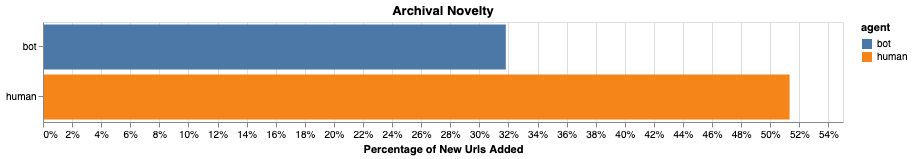

In [61]:
import altair
altair.renderers.enable('notebook')

novelty_df = pandas.DataFrame({
    'novelty': [
        len(sample.query('bot == "true" & new_url == "true"')) / len(sample.query('bot == "true"')),
        len(sample.query('bot == "false" & new_url == "true"')) / len(sample.query('bot == "false"'))
    ],
    'agent': ["bot", "human"]
})
                               
chart = altair.Chart(novelty_df).mark_bar().encode(
    altair.Y('agent:N', title=""),
    altair.X('novelty:Q', axis=altair.Axis(format='%', title="Percentage of New Urls Added")),
    altair.Color('agent:N')
)

chart = chart.properties(
    width=800,
    height=100,
    title='Archival Novelty'
)

chart